In [34]:
import torch
import torchvision
from danns_eg.data.mnist import get_sparse_permutation_invariant_fashionmnist_dataloaders
import matplotlib.pyplot as plt
import numpy as np
import danns_eg.deepdensenet as deepdensenets
import wandb
from torch.cuda.amp import GradScaler, autocast
import matplotlib.patches as mpatches

In [2]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [3]:
class NestedObject:
    def __init__(self, params):
        for key, value in params.items():
            if isinstance(value, dict):  # If the value is a dictionary, recursively convert it
                setattr(self, key, NestedObject(value))
            else:
                setattr(self, key, value)

In [4]:
 # model.is_dann, model.homeostasis, model.normtype, model.homeo_opt_exc, opt.lambda_homeo , opt.lambda_homeo_var, opt.use_sep_bias_gain_lrs, model.implicit_homeostatic_loss


params = {
    "model": {
        "is_dann": 1,
        "homeostasis": 0,
        "normtype": 0,
        "implicit_homeostatic_loss": 0,
        "homeo_opt_exc": 0,
        "hidden_layer_width": 200
        },
    "opt": {
        "lambda_homeo": 1,
        "lambda_homeo_var": 1,
        "use_sep_bias_gain_lrs": 0
    },
}

# Create the object from the nested dictionary
p = NestedObject(params)

In [5]:
# Load FashionMNIST dataset
dataloader = get_sparse_permutation_invariant_fashionmnist_dataloaders(permutation_invariant=False, brightness_factor=0.75)


In [6]:
dataiter = iter(dataloader['train'])
images, labels = next(dataiter)

In [7]:
api = wandb.Api(timeout=19)

In [22]:
bright_factor = 0.25
runs_dict = dict()
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bright_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

In [23]:

acc_s = dict.fromkeys(runs_dict.keys())
evaluations = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]
top_N = 10

for key in runs_dict:

    acc_s[key] = dict.fromkeys(evaluations)

    for run in runs_dict[key][:top_N]:
        params = {
            "model": {
                "is_dann": run.config['is_dann'],
                "homeostasis": run.config['homeostasis'],
                "normtype": run.config['normtype'],
                "implicit_homeostatic_loss": run.config['implicit_homeostatic_loss'],
                "homeo_opt_exc": run.config['homeo_opt_exc'],
                "hidden_layer_width": run.config['hidden_layer_width']
                },
            "opt": {
                "lambda_homeo": run.config['lambda_homeo'],
                "lambda_homeo_var": run.config['lambda_homeo_var'],
                "use_sep_bias_gain_lrs": run.config['use_sep_bias_gain_lrs']
            },
        }

        # Create the object from the nested dictionary
        p = NestedObject(params)

        model = deepdensenets.net(p)
        model.load_state_dict(torch.load(f"/network/scratch/r/roy.eyono/explicit_loss_models_fashionmnist_{bright_factor}/{run.name}.pth", map_location=torch.device('cuda')))
        model.cuda()
        model.eval()

        

        for eval in evaluations:

            loader = get_sparse_permutation_invariant_fashionmnist_dataloaders(permutation_invariant=False, brightness_factor_eval=eval)

            epoch_correct, total_ims = 0, 0
            for idx_batch, (ims, labs) in enumerate(loader['test']):
                with autocast():
                    ims, labs = ims.squeeze(1).cuda(), labs.cuda()
                    out = model(ims)
                    batch_correct = out.argmax(1).eq(labs).sum().cpu().item()
                    batch_acc = batch_correct / ims.shape[0] * 100
                    epoch_correct += batch_correct
                    total_ims += ims.shape[0]

            epoch_acc = epoch_correct / total_ims * 100
            if acc_s[key][eval] is not None:
                acc_s[key][eval].append(epoch_acc)
            else:
                acc_s[key][eval] = [epoch_acc]
            
            #print(epoch_acc)
    

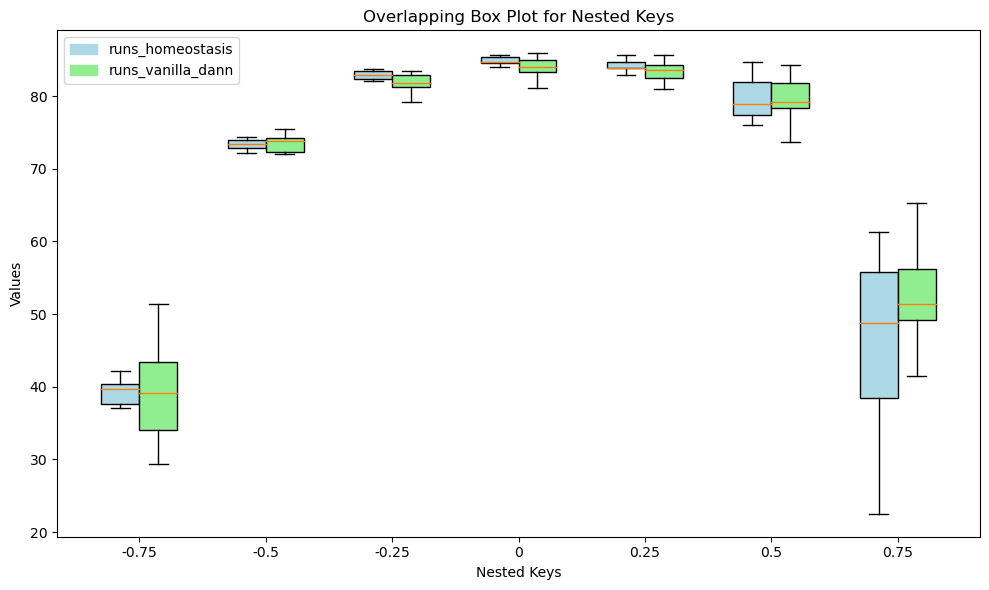

In [35]:
# Preparing data for the box plot
nested_keys = sorted(list(acc_s['runs_homeostasis'].keys()))  # Use sorted keys for consistency
homeostasis_data = [acc_s['runs_homeostasis'][key] for key in nested_keys]
vanilla_dann_data = [acc_s['runs_vanilla_dann'][key] for key in nested_keys]

# Plotting
plt.figure(figsize=(10, 6))

# Adding boxplots for both runs_homeostasis and runs_vanilla_dann on the same x-ticks
positions = np.arange(len(nested_keys))
box_width = 0.3  # Width for the boxplots

plt.boxplot(homeostasis_data, positions=positions - box_width / 2, widths=box_width, patch_artist=True, boxprops=dict(facecolor='lightblue'), showfliers=False)
plt.boxplot(vanilla_dann_data, positions=positions + box_width / 2, widths=box_width, patch_artist=True, boxprops=dict(facecolor='lightgreen'), showfliers=False)

# Customizing the plot
plt.xticks(ticks=positions, labels=[str(key) for key in nested_keys])
plt.title('Overlapping Box Plot for Nested Keys')
plt.xlabel('Nested Keys')
plt.ylabel('Values')
# Creating legend based on face colors
lightblue_patch = mpatches.Patch(color='lightblue', label='runs_homeostasis')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='runs_vanilla_dann')
plt.legend(handles=[lightblue_patch, lightgreen_patch])
plt.tight_layout()

# Display the plot
plt.show()